![sutd](sutd.png)
## <center>50.040 Natural Language Processing, Summer 2020<center>
<center>**Homework 4**

<center>**Due 31 July 2020, 5pm** <center>

**Write your student ID and name**

ID: 1003056

Name: Ivan Christian

Students whom you have discussed with (if any): Ng Jen Yang, Tee Zhi Yao

### Requirements:
- Use Python to complete this homework.
- Please list students with whom you have discussed (if any).
- Follow the honor code strictly.

In this homework, we'll implement ``IBM Model 1`` using the ``expectation–maximization (EM)`` algorithm. We need to estimate the  translation probabilities  $t(f|e)$ on a parallel corpus, where $e$ is a word from the English sentences and $f$ is a word from the corresponding foreign sentences. 

Note that there's a constraint for such probabilities:
$$\sum_f t(f|e)=1 , \ \ \  t(f|e) \ge 0  \quad (1)$$

**We'll use this constraint when initializing the translation probabilities in subsequent tasks.**

## Data
We'll use the English-French parallel corpus under the folder ``data/part1``, which contains a set of translation instances. As can be seen below each instance consists of an English-French sentence pair (note that we are translating from French into English, but as we discussed in class, when working on the translation model using IBM model 1, we are interested in generating French from English).



    Hop in.	Montez.
    Hug me.	Serre-moi dans tes bras !
    I left.	Je suis parti.

The dataset is obtained from [MXNET](http://data.mxnet.io/data/fra-eng.zip). Please run the provided code below to obtain the preprocessed English sentences and French sentences. Do not perform any further preprocessing. 


In [1]:
import seaborn as sns
import numpy as np
from time import time
from collections import Counter, defaultdict

from matplotlib import pyplot as plt
%matplotlib inline

# Part 1: Statistical Machine Translation \[25 points]

In [2]:
path = 'data/part1/en-fr.txt'
with open(path, 'r', encoding='utf8') as f:
    raw_text = f.read()

#Original code from 
#https://www.d2l.ai/chapter_recurrent-neural-networks
def preprocess_nmt(text):
    '''
    Arg:
        text: parallel text, string
    Return:
        out: preprocessed text, string
    '''
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: (
        True if char in (',', '!', '.') and prev_char != ' ' else False)
    out = [' '+char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text.lower())]
    out = ''.join(out)
    return out

def tokenize_nmt(text, num_examples = None):
    '''
    Args:
        text: parallel text, string
        num_examples: number of examples to be selected, int
    Returns:
        left: English sentences, list
        right: French sentences, list
    '''
    left, right = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            left.append(parts[0].split(' '))
            right.append(parts[1].split(' '))
    return left, right


In [3]:
#English sentences and corresponding French sentences
#Each sentence has been preprocessed and tokenized
text = preprocess_nmt(raw_text)
english_sents, french_sents = tokenize_nmt(text)

In [4]:
english_sents[:10], french_sents[:10]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who?'],
  ['wow', '!'],
  ['fire', '!'],
  ['help', '!'],
  ['jump', '.'],
  ['stop', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!'],
  ['au', 'feu', '!'],
  ['à', "l'aide", '!'],
  ['saute', '.'],
  ['ça', 'suffit', '!']])


### Quesiton 1 (3 points)
1. Implement ``word_pairs_in_corpus`` which finds out all the possible word pairs (alignments) $(e, f)$ that appear in all the instances of the English-French dataset ``english_sents``, ``french_sents``. Note that we need to pad each English sentence with the special token "NULL" at the beginning.
2. List down the 10 most frequent pairs. 
3. Count the number of unique pairs.

In [5]:
def word_pairs_in_corpus(en_sents, fr_sents):
    '''
    params:
        en_sents: list[list[str]]
        fr_sents: list[list[str]]
    return:
        align_counts: Dict()--- key: (english_word, french_word), value: counts of the word pair in the corpus
    '''
    align_counts = None
    # YOUR CODE HERE
    align_counts = defaultdict()
#     print(len(en_sents), len(fr_sents))
    
    sents_len = len(en_sents)
    for idx in range(sents_len):            
        
        for en_word in en_sents[idx]:
            for fr_word in fr_sents[idx]:
                if (en_word, fr_word) in align_counts:
                    align_counts[(en_word, fr_word)] += 1
                else:
                    align_counts[(en_word, fr_word)] = 1
    # END OF YOUR CODE
    return Counter(align_counts)

In [6]:
english_sents = [['NULL'] + sent for sent in english_sents]
align_counts = word_pairs_in_corpus(english_sents, french_sents)
align_counts.most_common(10), len(align_counts)

([(('.', '.'), 136734),
  (('NULL', '.'), 135221),
  (('i', '.'), 43189),
  (('NULL', 'je'), 39821),
  (('.', 'je'), 39096),
  (('NULL', 'de'), 35073),
  (('i', 'je'), 34415),
  (('to', '.'), 31647),
  (('.', 'de'), 30490),
  (('the', '.'), 29170)],
 1402126)

In [7]:
en_vocab = set([item[0] for item in align_counts.keys()])
fr_vocab = set([item[1] for item in align_counts.keys()])

In [8]:
len(en_vocab), len(fr_vocab)

(17430, 29741)

### Question 2 (2 points):

Implment the ``corpus_log_prob `` that computes the log probability of the corpus

In [9]:
def corpus_log_prob(en_sents, fr_sents, t):
    '''
    params:
        en_sents: list[list[str]]
        fr_sents: list[list[str]]
        t: Dict() --- contains translation probabilities. For example, t[(english_word, french_word)] = p
    return:
        logp: float --- log probability of the corpus
    '''
    logp = 0
    ### YOUR CODE HERE
    for en_sent, fr_sent in zip(en_sents, fr_sents):
        for fr_word in fr_sent:
            for en_word in en_sent:
            
                p = t[(en_word, fr_word)]
                if p != 0:
                    logp += np.log(p)
    
    # END OF YOUR CODE
    return logp

## Hard EM algorithm

### Question 3 (10 points)
Based on the word pairs obtained in Q1, implement ``Hard EM algorithm`` to calculate the  translation probabilities  $t(f|e)$ on the English-French corpus. 

It is possible that in the hard EM algorithm a word $\tilde{e}$ from an English sentence may not be aligned with any word from the corresponding French sentence. In this case, let us set the corresponding probabilities $t(f|\tilde{e})=\frac{1}{|V_f|}$ where $|V_f|$ is the size of the French vocabulary (in this case, the number of unique French words that ever appear in the training parallel corpus).

1. Implement ``init`` function which initializes the translation probability dictionary $t$ according to equation (1). You need to use ``numpy.random.rand()`` in this part.
2. Implement ``hard_EM`` function which runs one ``Expectation/Maximization`` iteration.
3. Run the training code

In [10]:
def init(word_pairs):
    '''
    Use np.random.rand() to initialize translation probabilities t(f|e)
    params:
        word_pairs: List[(str, str)] --- list of word pairs
    return:
        t: Dict(), key: (english_word, french_word), value: the initial probability t(f|e). For example, t[(a, un)] = 0.5
    '''
    np.random.seed(5)
    t = dict()
    ### YOUR CODE HERE
    from tqdm import tqdm
    
    t = defaultdict(float)
    value = defaultdict(float)
    
    
    for en_word, fr_word in word_pairs:
        rnd = np.random.rand()
        value[en_word] += rnd
        t[(en_word, fr_word)] = rnd
        
    for pair in word_pairs:
        t[pair] /= value[pair[0]]
        
    ### END OF YOUR CODE
    return dict(t)

In [11]:
def hard_EM(en_sents, fr_sents, fr_vocab, t):
    '''
    One 'Expectation', 'Maximization' iteration.
    params:
        en_sents: List[List[str]]
        fr_sents: List[List[str]]
        fr_vocab: int --- size of the French vocab
        t: Dict() --- translation probability dictionary from last iteration
        
    return:
        new_t: Dict() --- updated parameters, dictionary
    '''
    new_t = t
    ### YOUR CODE HERE
    import operator
    from tqdm import tqdm
    
    most_probable = {}
    value = defaultdict(float)
    out = dict()
    align_count_updated = dict()
    for key, value in t.items():
        en_word, fr_word = key
        out.setdefault(en_word, {})[fr_word] = value
        
    align_counts = word_pairs_in_corpus(en_sents, fr_sents)
    for key, value in align_counts.items():
        en_word, fr_word = key
        align_count_updated.setdefault(en_word, {})[fr_word] = value
    # E step
    for en_v in en_vocab:
        # find max from the new dict
        argmax_trans = max(out[en_v].items(), key=operator.itemgetter(1))

        most_probable.setdefault(en_v, {})[argmax_trans[0]] = argmax_trans[1]  
    #M Step 
    count_en = {k: sum(v.values()) for k, v in align_count_updated.items()}
    
    for en_sent, fr_sent in tqdm(zip(en_sents,fr_sents)):
        for en_word in en_sent:
            for fr_word in fr_sent:
                if en_word in most_probable.keys() :
                    if fr_word in most_probable[en_word].keys():
                        new_t[(en_word,fr_word)] = align_counts[(en_word,fr_word)]/count_en[en_word]
                    else:
                        new_t[(en_word,fr_word)] = 0 
                else:
                    new_t[(en_word,fr_word)] = 1/len(fr_vocab) 
    
    
    ### END OF YOUR CODE
    
    return new_t

In [12]:
############################################################
# Randomly initialized the probabilities under the contraint
############################################################
hard_t = init(list(align_counts.keys()))
    
##################
# Hard EM training
##################
iteration = 0
while iteration < 10:
    
    logp = corpus_log_prob(english_sents, french_sents, hard_t)    
    hard_t = hard_EM(english_sents, french_sents, fr_vocab, hard_t)
    print('Objective Function:', round(logp, 5))
    iteration += 1

167130it [00:02, 75660.25it/s]


Objective Function: -95137007.12011


167130it [00:02, 75108.77it/s]


Objective Function: -95144898.00715


167130it [00:02, 75430.19it/s]


Objective Function: -95143427.22856


167130it [00:02, 75095.35it/s]


Objective Function: -95137632.59236


167130it [00:02, 75058.56it/s]


Objective Function: -95136444.84452


167130it [00:02, 75194.98it/s]


Objective Function: -95136953.02436


167130it [00:02, 74754.81it/s]


Objective Function: -95124259.19635


167130it [00:02, 73650.04it/s]


Objective Function: -95123721.91823


167130it [00:02, 74232.23it/s]


Objective Function: -95122469.33936


167130it [00:02, 73413.59it/s]

Objective Function: -95118496.61013


### Visualization
Using 2D-heatmap, visualize the translation probability (namely $t(f|e)$) for each of the instances below:

    NULL tom loves chocolate .   tom adore le chocolat .    
    NULL it was a very exciting game .   c'était un jeu vraiment très excitant .  

In [13]:
def visualize_trans_prob(en, fr, t):
    '''
    Visualize the translation probability of an instance
    '''
    alignments = np.zeros([len(fr), len(en)])
    for i in range(len(fr)):
        for j in range(len(en)):
            alignments[i, j] = t[(en[j], fr[i])]
    sns.heatmap(alignments, cmap='PuBuGn', annot=True)
    _, _ = plt.yticks(np.arange(len(fr))+0.5, fr, rotation=0, fontsize=10)
    _, _ = plt.xticks(np.arange(len(en))+0.5, en, rotation=30, fontsize=10)

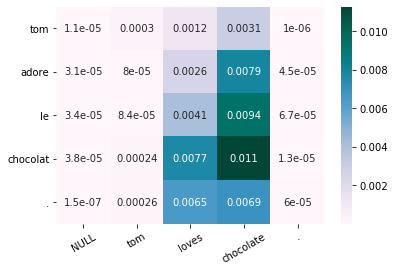

In [14]:
en = "NULL tom loves chocolate .".split()
fr = "tom adore le chocolat .".split()
visualize_trans_prob(en, fr, hard_t)

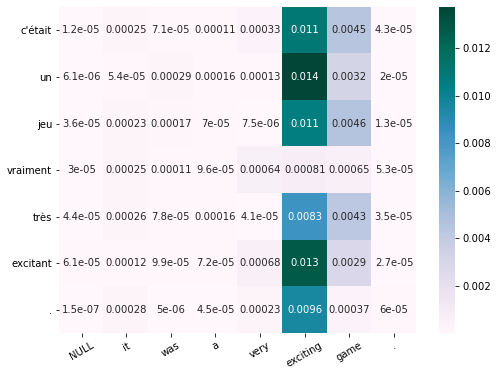

In [15]:
plt.figure(figsize=(8, 6))
en = "NULL it was a very exciting game .".split()
fr = "c'était un jeu vraiment très excitant .".split()
visualize_trans_prob(en, fr, hard_t)

## Soft EM algorithm

### Question 4 (10 points)

1. Implement ``soft_EM`` function which runs one ``Expectation/Maximization`` iteration.
2. Run the training code

In [23]:
def soft_EM(en_sents, fr_sents, t):
    '''
    params:
        en_sents: English sentences, list
        fr_sents: foreign sentences, list
    return:
        t: updated parameters, dictionary
    '''
    new_t = t
    ### YOUR CODE HERE
    import operator
    from tqdm import tqdm
    
    most_probable = {}
    value = defaultdict(float)
    out = dict()
    align_count_updated = dict()
    for key, value in t.items():
        en_word, fr_word = key
        out.setdefault(en_word, {})[fr_word] = value
        
    align_counts = word_pairs_in_corpus(en_sents, fr_sents)
    for key, value in align_counts.items():
        en_word, fr_word = key
        align_count_updated.setdefault(en_word, {})[fr_word] = value
    # E step
    for en_v in en_vocab:
        # find max from the new dict
        argmax_trans = sorted(out[en_v].items(), key=operator.itemgetter(1))

        
    count_en = {k: sum(v.values()) for k, v in align_count_updated.items()}
    
    for en_sent, fr_sent in tqdm(zip(en_sents,fr_sents)):
        for en_word in en_sent:
            for fr_word in fr_sent:
                new_t[(en_word,fr_word)] = align_counts[(en_word,fr_word)]/count_en[en_word]
    ## END OF YOUR CODE
    return new_t

Let us check the algorithm first using the objective value.

In [24]:
############################################################
# Randomly initialized the probabilities under the contraint
############################################################
soft_t = init(list(align_counts.keys()))
    
##################
# Hard EM training
##################
iteration = 0
while iteration < 15:
    
    logp = corpus_log_prob(english_sents, french_sents, soft_t)    
    soft_t = soft_EM(english_sents, french_sents, soft_t)  
    print('Objective Function:', round(logp, 5))
    iteration += 1

167130it [00:07, 22020.77it/s]


Objective Function: -95137007.12011


167130it [00:07, 21176.78it/s]


Objective Function: -61817991.96488


167130it [00:07, 22571.37it/s]


Objective Function: -61817991.96488


167130it [00:07, 21180.41it/s]


Objective Function: -61817991.96488


167130it [00:07, 22583.85it/s]


Objective Function: -61817991.96488


167130it [00:07, 22378.48it/s]


Objective Function: -61817991.96488


167130it [00:07, 21969.74it/s]


Objective Function: -61817991.96488


167130it [00:07, 22059.09it/s]


Objective Function: -61817991.96488


167130it [00:07, 21129.87it/s]


Objective Function: -61817991.96488


167130it [00:08, 20363.00it/s]


Objective Function: -61817991.96488


167130it [00:07, 21368.32it/s]


Objective Function: -61817991.96488


167130it [00:07, 21516.18it/s]


Objective Function: -61817991.96488


167130it [00:07, 21852.71it/s]


Objective Function: -61817991.96488


167130it [00:07, 21564.83it/s]


Objective Function: -61817991.96488


167130it [00:08, 20700.04it/s]


Objective Function: -61817991.96488


### Visualization

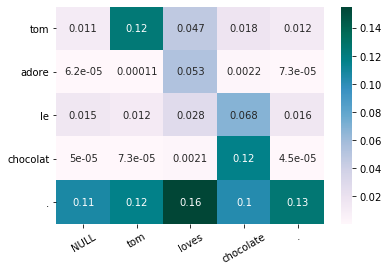

In [25]:
en = "NULL tom loves chocolate .".split()
fr = "tom adore le chocolat .".split()
visualize_trans_prob(en, fr, soft_t)

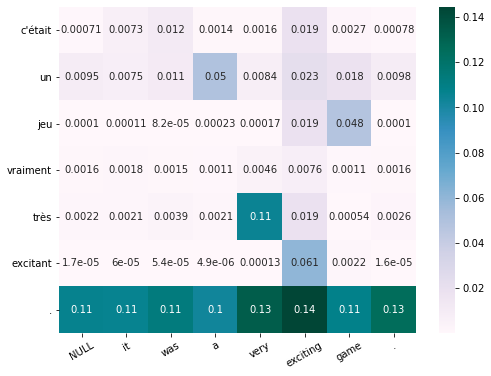

In [26]:
plt.figure(figsize=(8,6))
en = "NULL it was a very exciting game .".split()
fr = "c'était un jeu vraiment très excitant .".split()
visualize_trans_prob(en, fr, soft_t)